# Machine Learning e Imágenes en Python

## Actividad 4

### 1 Binarización: Clasificación dentro de una imagen en 2 clases, utilizando una variable: intensidad

Cargar en la notebook utilizando la librería OpenCV una imagen de manera monocroma que contenga un objeto claro u oscuro a destacar del fondo y luego:

* Binarizar la imagen por umbralado de la intensidad (utilizar el histograma de ser necesario para la elección del umbral), buscando separar el objeto deseado del fondo (unos,255 o rue en el objeto y ceros o False en el fondo).
* Mejorar la binarización con un filtro morfológico que crea adecuado.
* Encontrar los bordes del objeto utilizando operaciones morfológicas o gradiente morfológico.

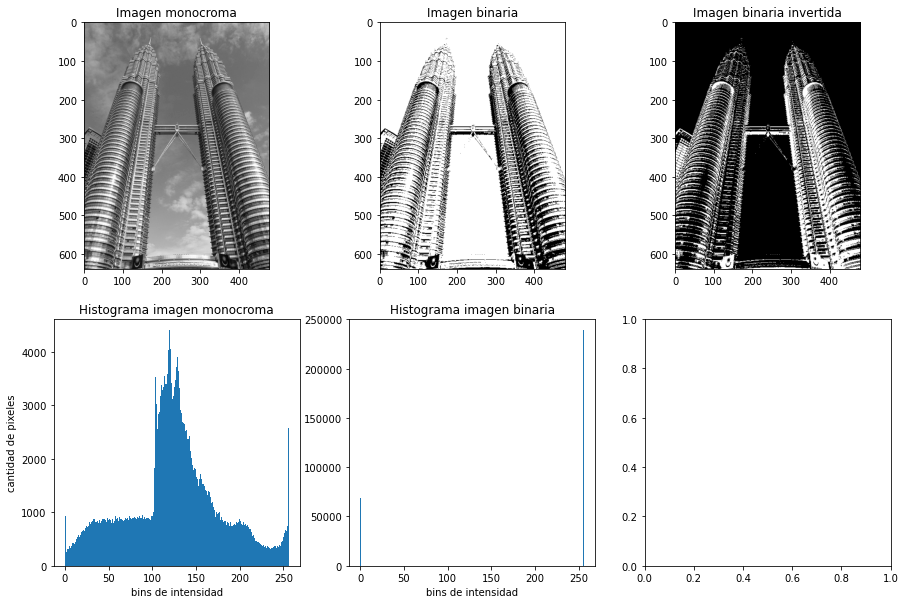

In [51]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

#PRIMERA PARTE.

img = cv2.imread('torrespetronas1.jpg', cv2.IMREAD_GRAYSCALE)

umbral=90 #arbitrario
binaria=(img>=umbral)
binaria=255*binaria.astype('uint8')

ret2,binaria2 = cv2.threshold(img,umbral,255,cv2.THRESH_BINARY_INV) 


fig, axs = plt.subplots(nrows=2, ncols=3, sharex=False)
axs=axs.ravel()
fig.set_figheight(10)
fig.set_figwidth(15)
axs[0].imshow(img, cmap='gray',vmin=0 ,vmax=255)
axs[0].set_title('Imagen monocroma')
axs[1].imshow(binaria, cmap='gray',vmin=0 ,vmax=255)
axs[1].set_title('Imagen binaria')
axs[2].imshow(binaria2, cmap='gray',vmin=0 ,vmax=255)
axs[2].set_title('Imagen binaria invertida')


axs[3].hist(img[:,:].ravel(), 256,[0,256] ) 
axs[3].set_xlabel('bins de intensidad')
axs[3].set_ylabel('cantidad de pixeles')
axs[3].set_title('Histograma imagen monocroma')
axs[4].hist(binaria[:,:].ravel(), 256,[0,256] ) 
axs[4].set_title('Histograma imagen binaria')
axs[4].set_xlabel('bins de intensidad')


plt.show()

SEGUNDA PARTE:
**A continuación busco un filtro que me permita homogenizar al edificio, el que mejor se adecúa es el filtro morfológico de dilatación.
Esto es de esperar ya que al dilatar la imagen, las regiones de unos (blancas) buscan aumentar su tamaño y rellenar intersticios, que es lo que necesitamos para rellenar als ventanas y poder ver al edificio como unidad.**

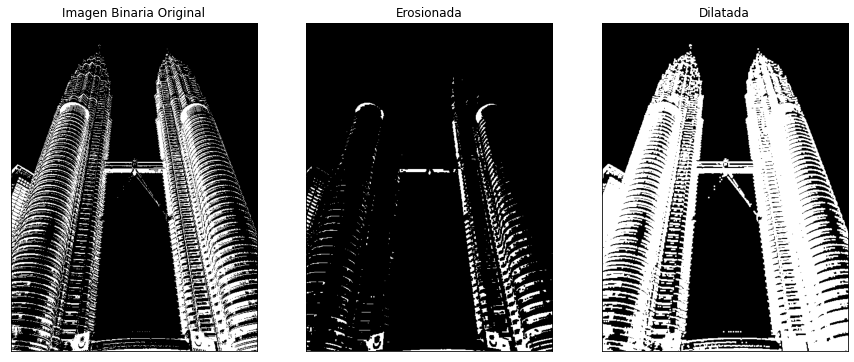

In [52]:
umbral_otsu,img_binaria = cv2.threshold(binaria2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

kernel = np.ones((3,3),np.uint8)#creamos el elemento estructurante 

bin_erosionada = cv2.erode(img_binaria,kernel,iterations = 1)# erosionamos la imagen binaria, con el kernel, una sola vez
bin_dilatada = cv2.dilate(img_binaria,kernel,iterations = 1) #dilatamos la imagen binaria

#imagen binaria, erosionada y dilatada
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.subplot(1,3,1), plt.imshow(img_binaria,cmap='gray'),plt.title('Imagen Binaria Original'),plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(bin_erosionada,cmap='gray'),plt.title('Erosionada'),plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(bin_dilatada,cmap='gray'),plt.title('Dilatada'),plt.xticks([]), plt.yticks([])
plt.show()

TERCERA PARTE: 
**A continuación aplico suavizado gaussiano y luego el filtro laplaciano intensificado
Al hacer el suavizado primero logro eliminar el ruido y ensanchar los bordes, para luego realizar la detección de bordes con el filtro laplaciano.**


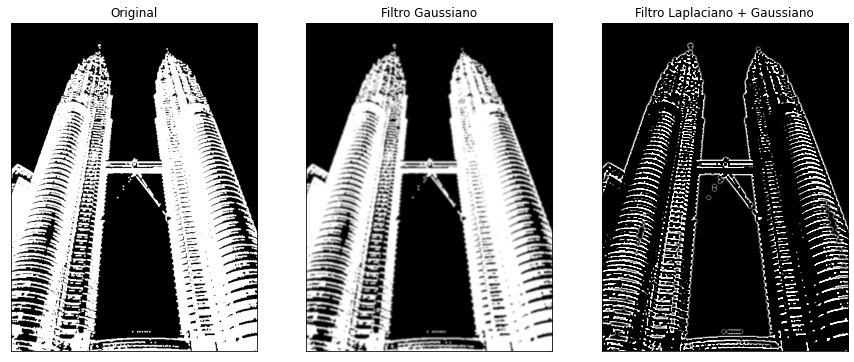

In [53]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

#gaussiano
n=7

blur = cv2.GaussianBlur(bin_dilatada,(n,n),0)

fig = plt.gcf()
fig.set_size_inches(15, 10)

#laplaciano
laplacian = cv2.Laplacian(blur, cv2.CV_64F)

plt.subplot(131),plt.imshow(bin_dilatada,cmap='gray',vmin=0,vmax=255),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(blur,cmap='gray',vmin=0,vmax=255),plt.title('Filtro Gaussiano')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(10*laplacian,cmap='gray',vmin=0,vmax=255),plt.title('Filtro Laplaciano + Gaussiano')
plt.xticks([]), plt.yticks([])

plt.show()

### 2 Clasificación dentro de una imagen: 4 clases, 3 variables o features: R,G,B

Cargue una imagen RGB a elección que a la vista tenga 4 clases identificables:

* Describa con sus palabras brevemente las 4 clases que ve en la imagen.
* Utilice k-medias con k=4 cantidad de clusters para realizar clasificación no supervisada de la imagen. Muestre los resultados, tanto en el espacio RGB como en la disposición de los clusters encontrados en la imagen.
* Realice una clasificación semi-supervisada: 
 - etiquetando manualmente pixeles de las 4 clases. muestre los pixeles etiquetados en el espacio RGB. 
 - reclasificando toda la imagen según esas cuatro clases.
 - Muestre los resultados y realice una mejora de la clasificación utilizando un filtro de moda
 * Comente los resultados. 
 
 Ayuda: Utilice la distancia euclídea. Normalice las observaciones si lo requiere su conjunto de datos ("distancia del coseno") 

**CLASIFICACIÓN NO SUPERVISADA, PRIMERA PARTE**

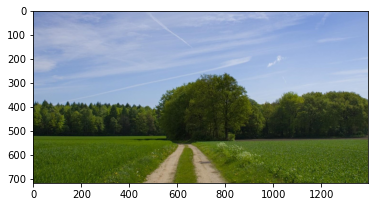

In [68]:
#CARGA DE IMAGEN RGB
import cv2
campo_cv=cv2.imread('campo22.jpg')
campo=campo_cv.copy()
campo[:,:,[2,1,0]]=campo_cv #De BGR a RGB

from matplotlib import pyplot as plt
plt.imshow(campo)
plt.show()  

**Las cuatro clases identificables son PASTO, CAMINO , ARBOLES, CIELO.**

In [69]:
# Armado de la base de pixeles como Data Frame
import numpy as np
dims=campo.shape
cant_filas=dims[0]
cant_columnas=dims[1]
cant_pixeles=cant_filas*cant_columnas
data0=np.zeros([cant_pixeles,4],dtype='int')
for f in range(cant_filas):
    for c in range(cant_columnas):
        nro=f*cant_columnas+c
        data0[nro,0]=nro
        data0[nro,1:4]=campo[f,c,:]

import pandas as pd
df = pd.DataFrame(data0, columns=["pixel_id","rojo","verde","azul"])

print(df.shape)
print('Base de pixeles:')
df.head()  

(1000932, 4)
Base de pixeles:


,pixel_id,rojo,verde,azul
0,0,127,145,191
1,1,127,145,191
2,2,127,145,191
3,3,127,145,191
4,4,128,146,192


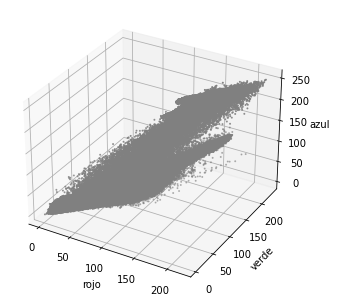

In [70]:
#Visualización de los datos
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

variables=["rojo","verde","azul"]
ax.scatter(df[variables[0]].values, df[variables[1]].values, df[variables[2]].values,c='gray', s=1)
ax.set_xlabel(variables[0])
ax.set_ylabel(variables[1])
ax.set_zlabel(variables[2])
plt.show()

In [71]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

df_pix=df.drop('pixel_id',axis=1) #saco la columna de los pixeles_id que es la numeración y dejo los RGB

kmeans = KMeans(n_clusters=4)
kmeans.fit(df_pix) #corro todos los pixeles
df_clusters=df.copy()
df_clusters['kmedias_4']=kmeans.labels_ #agrego columna a mi tabla
df_clusters.head()

,pixel_id,rojo,verde,azul,kmedias_4
0,0,127,145,191,1
1,1,127,145,191,1
2,2,127,145,191,1
3,3,127,145,191,1
4,4,128,146,192,1


se grafican de a dos (dimensión 2)


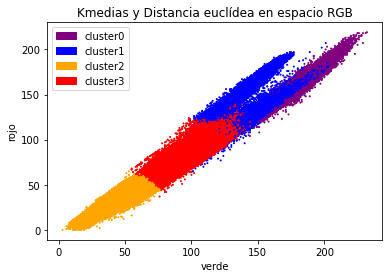

In [72]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

colores=['purple','blue','orange','red']
variables=["rojo","verde","azul"]

variable1=variables[1]
variable2=variables[0]

f1 = df_clusters[variable1].values
f2 = df_clusters[variable2].values
f3 = df_clusters.kmedias_4

asignar=[]
l=len(f3)
print('se grafican de a dos (dimensión 2)')

for k in range(l): #for index, row in filtered_data.iterrows():
    asignar.append(colores[f3[k]-1])
    
plt.scatter(f1, f2, c=asignar, s=1)
plt.xlabel(variable1)
plt.ylabel(variable2)
patch1 = mpatches.Patch(color=colores[0], label='cluster0')
patch2 = mpatches.Patch(color=colores[1], label='cluster1')
patch3 = mpatches.Patch(color=colores[2], label='cluster2')
patch4 = mpatches.Patch(color=colores[3], label='cluster3')
plt.legend(handles=[patch1,patch2,patch3,patch4])
plt.title('Kmedias y Distancia euclídea en espacio RGB')
plt.show()

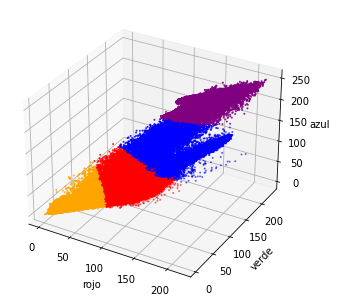

In [73]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(df[variables[0]].values, df[variables[1]].values, df[variables[2]].values,c=asignar, s=1)
ax.set_xlabel(variables[0])
ax.set_ylabel(variables[1])
ax.set_zlabel(variables[2])
plt.show()

In [74]:
clasif_km=df_clusters.kmedias_4.values.reshape(campo.shape[0] ,campo.shape[1]) #sin for!! con reshape, todo el vector de etiquetas me lo acomode en tantas filas y tantas columnas, o sea en una sola capa y cada valos estara entre 0,1,2 y 3 segun cluster

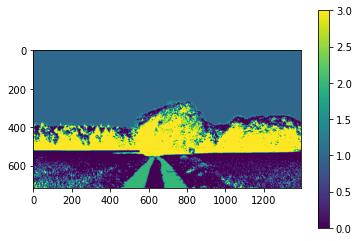

In [75]:
plt.imshow(clasif_km)
plt.colorbar()

Se identifican 4 zonas claramente:
FONDO O CIELO : 1
ARBOLES:3
PASTO:O,5
CAMINO:2

No creo necesario realizar la ditancia del coseno ya que mis datos fueron clasificados correctamente, en las 4 regiones de interes. No se obtuvo buen resultado aplicando la distancia del coseno. 

**CLASIFICACIÓN SEMISUPERVISADA, SEGUNDA PARTE**

In [21]:
import cv2
campo_cv=cv2.imread('campo22.jpg')
campo=campo_cv.copy()
campo[:,:,[2,1,0]]=campo_cv

In [22]:
import numpy as np
dims=campo.shape
cant_filas=dims[0]
cant_columnas=dims[1]
cant_pixeles=cant_filas*cant_columnas
data0=np.zeros([cant_pixeles,4],dtype='int')
for f in range(cant_filas):
    for c in range(cant_columnas):
        nro=f*cant_columnas+c
        data0[nro,0]=nro
        data0[nro,1:4]=campo[f,c,:]
        
import pandas as pd
df = pd.DataFrame(data0, columns=["pixel_id","rojo","verde","azul"])

print(df.shape)
print('Base de pixeles:')
df.head() 

(1000932, 4)
Base de pixeles:


,pixel_id,rojo,verde,azul
0,0,127,145,191
1,1,127,145,191
2,2,127,145,191
3,3,127,145,191
4,4,128,146,192


In [41]:
#pasto
showCrosshair = False
fromCenter = False
roi1 = cv2.selectROI("delimite la ROI PASTO con mouse +ent+tecla", campo_cv, fromCenter, showCrosshair)
cv2.waitKey() #espera pulsado de tecla. tengo que seleccionar sector, luego enter, y luego salgo con tecla
print('ROI1:',roi1)
print('(columna, fila, anchocol, anchofila)')
cv2.destroyAllWindows()


ROI1: (303, 564, 145, 77)
(columna, fila, anchocol, anchofila)


In [42]:
#Camino
showCrosshair = False
fromCenter = False
roi2 = cv2.selectROI("delimite la ROI CAMINO con mouse+ent+tecla", campo_cv, fromCenter, showCrosshair)
cv2.waitKey() #espera pulsado de tecla. 
print('ROI2:',roi2)
print('(columna, fila, anchocol, anchofila)')
cv2.destroyAllWindows()

ROI2: (697, 656, 49, 54)
(columna, fila, anchocol, anchofila)


In [43]:
#cielo
showCrosshair = False
fromCenter = False
roi3 = cv2.selectROI("delimite la ROI CIELO con mouse+ent+tecla", campo_cv, fromCenter, showCrosshair)
cv2.waitKey() #espera pulsado de tecla. 
print('ROI3:',roi3)
print('(columna, fila, anchocol, anchofila)')
cv2.destroyAllWindows()

ROI3: (817, 153, 166, 75)
(columna, fila, anchocol, anchofila)


In [44]:
#arboles
showCrosshair = False
fromCenter = False
roi4 = cv2.selectROI("delimite la ROI ARBOLES con mouse+ent+tecla", campo_cv, fromCenter, showCrosshair)
cv2.waitKey() #espera pulsado de tecla. 
print('ROI4:',roi4)
print('(columna, fila, anchocol, anchofila)')
cv2.destroyAllWindows()

ROI4: (847, 407, 160, 77)
(columna, fila, anchocol, anchofila)


In [45]:
rois=[roi1,roi2,roi3,roi4]

In [52]:
import numpy as np
cantidad=0
for i in range(4):
    cantidad=cantidad+(rois[i][2]*rois[i][3])
print (cantidad)
data=np.zeros([cantidad,5],dtype='int')
target=np.zeros(cantidad,dtype='int')
cuenta=0
for i in range(4):
    roi=rois[i]
    
    for fil in range (roi[1],roi[1]+roi[3]):
        for col in range (roi[0],roi[0]+roi[2]):
            nro=fil*cant_columnas+col
            data[cuenta,0]=nro
            data[cuenta,1:4]=campo[fil,col,:]
            data[cuenta,4]=i+1
            target[cuenta]=i+1
            cuenta=cuenta+1


import pandas as pd
df_etiquetado = pd.DataFrame(data, columns=["pixel_id","rojo","verde","azul","etiqueta"])
print(df_etiquetado.shape)
print('Base de pixeles etiquetados:')
df_etiquetado.head()

38581
(38581, 5)
Base de pixeles etiquetados:


,pixel_id,rojo,verde,azul,etiqueta
0,787647,57,83,9,1
1,787648,68,92,18,1
2,787649,75,99,25,1
3,787650,72,96,22,1
4,787651,74,98,22,1


cantidad de muestras etiquetadas: 38581


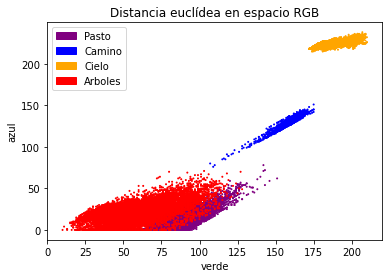

In [54]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

colores=['purple','blue','orange','red']
variables=["rojo","verde","azul"]

variable1=variables[1]
variable2=variables[2]

f1 = df_etiquetado[variable1].values
f2 = df_etiquetado[variable2].values
f3 = target

asignar=[]
l=len(f3)
print('cantidad de muestras etiquetadas:',l)

for k in range(l): #for index, row in filtered_data.iterrows():
    if(f3[k]==1):
        asignar.append(colores[0])
    elif(f3[k]==2):
        asignar.append(colores[1])
    elif(f3[k]==3):
        asignar.append(colores[2])
    else:
        asignar.append(colores[3])
    
    
plt.scatter(f1, f2, c=asignar, s=1)
plt.xlabel(variable1)
plt.ylabel(variable2)
patch1 = mpatches.Patch(color=colores[0], label='Pasto')
patch2 = mpatches.Patch(color=colores[1], label='Camino')
patch3 = mpatches.Patch(color=colores[2], label='Cielo')
patch4 = mpatches.Patch(color=colores[3], label='Arboles')
plt.legend(handles=[patch1,patch2,patch3,patch4])
plt.title('Distancia euclídea en espacio RGB')
plt.show()


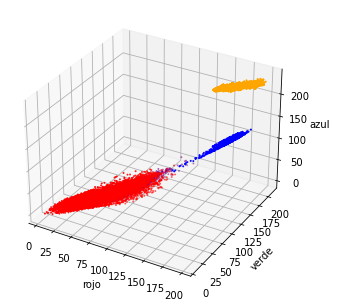

In [55]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(df_etiquetado[variables[0]].values, df_etiquetado[variables[1]].values, df_etiquetado[variables[2]].values,c=asignar, s=1)
ax.set_xlabel(variables[0])
ax.set_ylabel(variables[1])
ax.set_zlabel(variables[2])
plt.show()

#pyplot.show()

In [56]:
from sklearn.neighbors import KNeighborsClassifier
n_neighbors = 4
data_rgb=data[:,1:4] #data rgb: son los datos crudos etiquetados de los roi, y el target las etiquetas que les puse

knn = KNeighborsClassifier(n_neighbors)
knn.fit(data_rgb, target)
print('Presición (Accuracy) del clasificador K-NN en el conjunto de entrenamiento: {:.2f}'
     .format(knn.score(data_rgb, target)))

#clasifica a los vecinos en el espacio RGB o sea en cuanto a nivelde brillo

Presición (Accuracy) del clasificador K-NN en el conjunto de entrenamiento: 1.00


(717, 1396, 3)
[4]


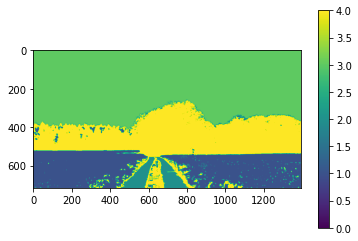

In [57]:
#clasifico usando mi clasificador, guardando en una matriz con el mismo tamaño de cmapo epro en vez de tener un pixel voy a tener la etiqueta
#recorro la imagen todos los pixeles y guardo etiquetas segun mi clasificador
a=campo.shape
print(a)
clasif=np.zeros(a[0:2],dtype='int')
print(knn.predict([[40, 80, 40]]))
for i in range(a[0]): #filas
    for j in range(a[1]): #columnas
        clasif[i,j]=knn.predict([campo[i,j,:]])        
clasif[0,0]=0 #para unificar paletas (con 4 colores)         
plt.imshow(clasif)
plt.colorbar()
plt.show()
 #maximos , minimos , medianas y eso son filtros preparados para datos numericos, no nos sirve para promediar estos datos que son datos categoricos, aca deberiamos usar el filtro de moda para rellenar esos puntitos!: que es laclase mas repetida en un entorno!       

In [58]:
from statistics import mode
clasif2=clasif.copy()
for i in range(2,a[0]-2): #filas
    for j in range(2,a[1]-2): #columnas
        try:
            clasif2[i,j]=mode(clasif[i-2:i+3,j-2:j+3].ravel())
        except:
            clasif2[i,j]=clasif[i,j]
clasif2[0,0]=0 #para unificar paletas (con 4 colores) 

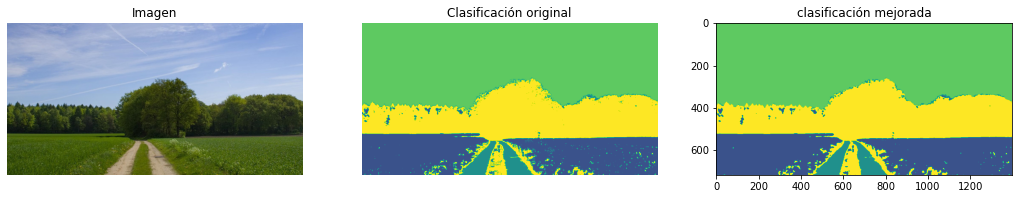

In [59]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(18)
axs[0].imshow(campo)
axs[0].set_title("Imagen")
axs[0].axis('off')
axs[1].imshow(clasif)
axs[1].set_title("Clasificación original")
axs[1].axis('off')
axs[2].imshow(clasif2)
axs[2].set_title('clasificación mejorada')
#axs[2].axis('off')
plt.show()

No se observa mejoria significativa con el filtro de moda. Apenas puede verse en la región del pasto.

### 3 Redes Neuronales

Considerando la base de datos mnist
* Utilice **dos** redes totalmente conectadas (fully conected) para clasificar cada imagen en los 10 tipos de dígitos y compárelas en cuanto a su desempeño y overfitting (sobreajuste a los datos de entrenamiento y mal ajuste en los datos de test).
* Utilice **dos** redes neuronales convolucionales para clasificar cada imagen en los 10 tipos de dígitos y compárelas en cuanto a su complejidad (cantidad de parámetros) y overfitting. Comente resultados
* Realice aumentación de datos utilizando una rotación de +5 y -5 grados de cada imagen. ¿Cuanto se aumenta la base?

In [58]:
import tensorflow
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import cv2
import random
import numpy as np

**PROCESAMIENTO DE DATOS**

In [59]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [60]:
X_train = X_train.reshape(60000, 784)

In [61]:
X_test = X_test.reshape(10000, 784)

In [62]:
y_train = keras.utils.to_categorical(y_train)

In [63]:
y_test = keras.utils.to_categorical(y_test)

**ESTRUCTURA DE LA PRIMERA RED NEURONAL FULLY CONECTED**

In [15]:
#CAPA DE ENTRADA
Imagen_de_entrada = layers.Input(shape = (784,))

In [17]:
#CAPAS OCULTAS
Capa1 = layers.Dense(units = 64, activation = 'relu')(Imagen_de_entrada)

In [18]:
Capa2 = layers.Dense(units = 128, activation = 'relu')(Capa1)

In [19]:
#CAPA DE SALIDA
Salida = layers.Dense(units = 10, activation = 'softmax')(Capa2)

In [20]:
#MODELO RED NEURONAL
Red_Neuronal = keras.Model(inputs = Imagen_de_entrada, outputs = Salida)

In [21]:
#COMPILACIÓN
Red_Neuronal.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [22]:
Historia = Red_Neuronal.fit(x = X_train, y = y_train, epochs = 10, batch_size = 32, validation_data = (X_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.4219 - accuracy: 0.8295 - val_loss: 0.4860 - val_accuracy: 0.8875
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4203 - accuracy: 0.9006 - val_loss: 0.3673 - val_accuracy: 0.9158
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3641 - accuracy: 0.9144 - val_loss: 0.3316 - val_accuracy: 0.9213
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3185 - accuracy: 0.9249 - val_loss: 0.3483 - val_accuracy: 0.9291
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2742 - accuracy: 0.9324 - val_loss: 0.3138 - val_accuracy: 0.9195
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2399 - accuracy: 0.9382 - val_loss: 0.2353 - val_accuracy: 0.9422
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2007 - accuracy: 0.9465 - val_loss: 0.2231 - val_accuracy:

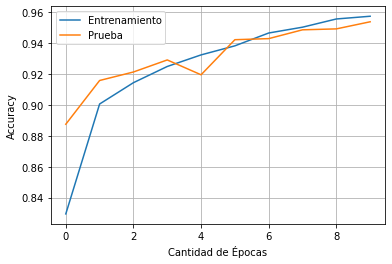

In [23]:
plt.plot(Historia.history['accuracy'], label = 'Entrenamiento') 
plt.grid()
plt.xlabel('Cantidad de Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
Red_Neuronal.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 59,850
Trainable params: 59,850
Non-trainable params: 0
_________________________________________________________________


**ESTRUCTURA DE LA SEGUNDA RED NEURONAL FULLY CONECTED**

In [34]:
#CAPA DE ENTRADA
Imagen_de_entrada2 = layers.Input(shape = (784,))


In [35]:
#CAPAS OCULTAS
Capa11 = layers.Dense(units = 50, activation = 'sigmoid')(Imagen_de_entrada2)
Capa22 = layers.Dense(units = 125, activation = 'relu')(Capa11)


In [36]:
#CAPA DE SALIDA
Salida2 = layers.Dense(units = 10, activation = 'softmax')(Capa22)


In [38]:
#MODELO RED NEURONAL
Red_Neuronal2 = keras.Model(inputs = Imagen_de_entrada2, outputs = Salida2)


In [39]:
#COMPILACIÓN
Red_Neuronal2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [40]:
Historia2 = Red_Neuronal2.fit(x = X_train, y = y_train, epochs = 15, batch_size = 64, validation_data = (X_test, y_test))

Epoch 1/15
938/938 [==============================] - 2s 2ms/step - loss: 0.6004 - accuracy: 0.8222 - val_loss: 0.4132 - val_accuracy: 0.8698
Epoch 2/15
938/938 [==============================] - 2s 2ms/step - loss: 0.4139 - accuracy: 0.8720 - val_loss: 0.3712 - val_accuracy: 0.8872
Epoch 3/15
938/938 [==============================] - 2s 2ms/step - loss: 0.3746 - accuracy: 0.8811 - val_loss: 0.3570 - val_accuracy: 0.8919
Epoch 4/15
938/938 [==============================] - 2s 2ms/step - loss: 0.3323 - accuracy: 0.8970 - val_loss: 0.3122 - val_accuracy: 0.9020
Epoch 5/15
938/938 [==============================] - 2s 2ms/step - loss: 0.3022 - accuracy: 0.9055 - val_loss: 0.2886 - val_accuracy: 0.9091
Epoch 6/15
938/938 [==============================] - 2s 2ms/step - loss: 0.2915 - accuracy: 0.9093 - val_loss: 0.2974 - val_accuracy: 0.9092
Epoch 7/15
938/938 [==============================] - 2s 2ms/step - loss: 0.2816 - accuracy: 0.9112 - val_loss: 0.2869 - val_accuracy: 0.9076
Epoch 

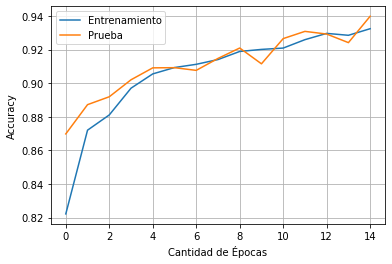

In [42]:
plt.plot(Historia2.history['accuracy'], label = 'Entrenamiento') 
plt.plot(Historia2.history['val_accuracy'], label = 'Prueba')
plt.grid()
plt.xlabel('Cantidad de Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [43]:
Red_Neuronal2.summary()

Model: "functional_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                39250     
_________________________________________________________________
dense_8 (Dense)              (None, 125)               6375      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1260      
Total params: 46,885
Trainable params: 46,885
Non-trainable params: 0
_________________________________________________________________


**ESTRUCTURA DE LA PRIMERA RED NEURONAL CONVOLUCIONAL**

In [85]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [86]:
#CAPA DE ENTRADA
Imagen_de_entrada = layers.Input(shape = (28, 28, 1))

In [87]:
#CAPA DE CONVOLUCIÓN
X = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = None)(Imagen_de_entrada)

In [88]:
#CAPA DE NORMALIZACIÓN
X = layers.BatchNormalization()(X)

X = layers.Activation("relu")(X)

In [89]:
#CAPA DE MAX-POOLING
X = layers.MaxPooling2D(pool_size = (2, 2))(X)

In [90]:
X = layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = None)(X)

X = layers.BatchNormalization()(X)

X = layers.Activation("relu")(X)

Flatten = layers.Flatten()(X) 

X = layers.Dense(256, activation = "sigmoid")(Flatten)

X = layers.Dense(64, activation = "sigmoid")(X)

Salida = layers.Dense(units = 10, activation = 'softmax')(X)

Red_Neuronal = keras.Model(inputs = Imagen_de_entrada, outputs = Salida)

Red_Neuronal.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

Historia = Red_Neuronal.fit(x = X_train, y = y_train, epochs = 10, batch_size = 32, validation_data = (X_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 118s 63ms/step - loss: 0.1325 - accuracy: 0.9712 - val_loss: 0.0522 - val_accuracy: 0.9846
Epoch 2/10
1875/1875 [==============================] - 106s 56ms/step - loss: 0.0452 - accuracy: 0.9868 - val_loss: 0.0410 - val_accuracy: 0.9880
Epoch 3/10
1875/1875 [==============================] - 97s 52ms/step - loss: 0.0339 - accuracy: 0.9895 - val_loss: 0.0655 - val_accuracy: 0.9802
Epoch 4/10
1875/1875 [==============================] - 85s 45ms/step - loss: 0.0268 - accuracy: 0.9916 - val_loss: 0.0434 - val_accuracy: 0.9862
Epoch 5/10
1875/1875 [==============================] - 87s 46ms/step - loss: 0.0202 - accuracy: 0.9936 - val_loss: 0.0324 - val_accuracy: 0.9898
Epoch 6/10
1875/1875 [==============================] - 82s 44ms/step - loss: 0.0161 - accuracy: 0.9948 - val_loss: 0.0350 - val_accuracy: 0.9891
Epoch 7/10
1875/1875 [==============================] - 84s 45ms/step - loss: 0.0129 - accuracy: 0.9959 - val_loss: 0.0315

In [91]:
Red_Neuronal.summary()

Model: "functional_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 11, 11, 64)       

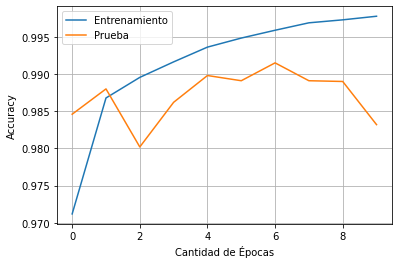

In [92]:
plt.plot(Historia.history['accuracy'], label = 'Entrenamiento')
plt.plot(Historia.history['val_accuracy'], label = 'Prueba')
plt.grid()
plt.xlabel('Cantidad de Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**ESTRUCTURA DE LA PRIMERA RED NEURONAL CONVOLUCIONAL**

In [99]:
#CAPA DE ENTRADA
Imagen_de_entrada = layers.Input(shape = (28, 28, 1))

In [100]:
#CAPA DE CONVOLUCIÓN
X = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = None)(Imagen_de_entrada)

In [101]:
#CAPA DE NORMALIZACIÓN
X = layers.BatchNormalization()(X)

X = layers.Activation("relu")(X)

In [102]:
#CAPA DE MAX-POOLING
X = layers.MaxPooling2D(pool_size = (2, 2))(X)

In [103]:
X = layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = None)(X)

X = layers.BatchNormalization()(X)

X = layers.Activation("relu")(X)

Flatten = layers.Flatten()(X) 

X = layers.Dense(64, activation = "relu")(Flatten)

X = layers.Dense(32, activation = "relu")(X)

Salida = layers.Dense(units = 10, activation = 'softmax')(X)

Red_Neuronal = keras.Model(inputs = Imagen_de_entrada, outputs = Salida)

Red_Neuronal.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

Historia = Red_Neuronal.fit(x = X_train, y = y_train, epochs = 10, batch_size = 32, validation_data = (X_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 94s 50ms/step - loss: 0.1296 - accuracy: 0.9606 - val_loss: 0.1387 - val_accuracy: 0.9563
Epoch 2/10
1875/1875 [==============================] - 92s 49ms/step - loss: 0.0530 - accuracy: 0.9839 - val_loss: 0.0529 - val_accuracy: 0.9850
Epoch 3/10
1875/1875 [==============================] - 80s 43ms/step - loss: 0.0365 - accuracy: 0.9889 - val_loss: 0.0449 - val_accuracy: 0.9868
Epoch 4/10
1875/1875 [==============================] - 85s 45ms/step - loss: 0.0293 - accuracy: 0.9911 - val_loss: 0.0541 - val_accuracy: 0.9830
Epoch 5/10
1875/1875 [==============================] - 78s 42ms/step - loss: 0.0214 - accuracy: 0.9933 - val_loss: 0.0343 - val_accuracy: 0.9893
Epoch 6/10
1875/1875 [==============================] - 63s 33ms/step - loss: 0.0181 - accuracy: 0.9942 - val_loss: 0.0538 - val_accuracy: 0.9851
Epoch 7/10
1875/1875 [==============================] - 67s 36ms/step - loss: 0.0150 - accuracy: 0.9951 - val_loss: 0.0376 -

In [105]:
Red_Neuronal.summary()

Model: "functional_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_6 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
activation_6 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 11, 11, 64)      

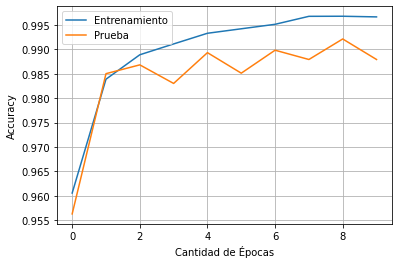

In [106]:
plt.plot(Historia.history['accuracy'], label = 'Entrenamiento')
plt.plot(Historia.history['val_accuracy'], label = 'Prueba')
plt.grid()
plt.xlabel('Cantidad de Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Utilizando  las funciones de activación RELU la cantidad de parametros se redujo a mas de la mitad.

In [107]:
from PIL import Image

In [111]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [112]:
print(X_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


In [113]:
def rotacion(imagen, angulo):
    imagen = Image.fromarray(imagen)
    imagen_rotada = imagen.rotate(angle = angulo, expand = False)
    return np.array(imagen_rotada)

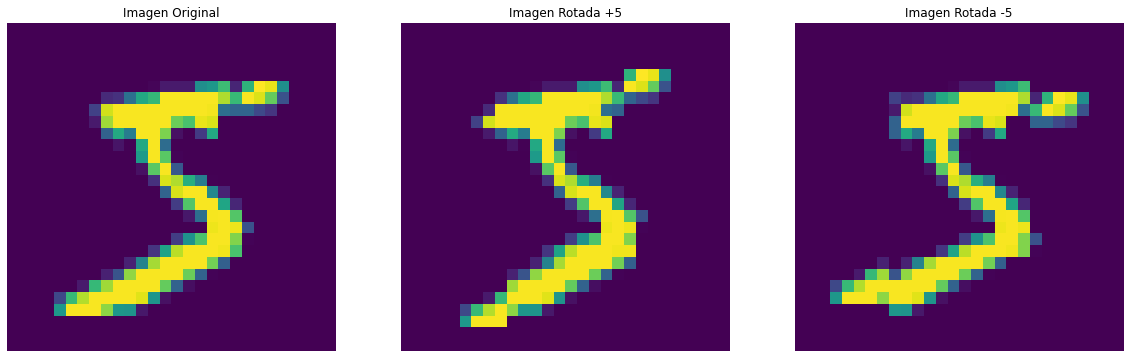

(28, 28)


In [114]:
fig, ax = plt.subplots(1, 3, figsize = (20, 15))

ax[0].imshow(X_train[0]);
ax[0].axis('off')
ax[0].set_title('Imagen Original')

ax[1].imshow(rotacion(X_train[0], 5));
ax[1].axis('off')
ax[1].set_title('Imagen Rotada +5')

ax[2].imshow(rotacion(X_train[0], -5));
ax[2].axis('off')
ax[2].set_title('Imagen Rotada -5')

plt.show()

print(rotacion(X_train[0], 5).shape)

In [116]:
def aumentacion(imagenes, etiquetas):
    lista_imagenes = []
    lista_etiquetas = []
    
    for i in range(imagenes.shape[0]):
        
        imagen, etiqueta = imagenes[i], etiquetas[i]

        lista_imagenes.append(imagen)
        lista_etiquetas.append(etiqueta)

        lista_imagenes.append(rotacion(imagen, 5))
        lista_etiquetas.append(etiqueta)    

        lista_imagenes.append(rotacion(imagen, -5))
        lista_etiquetas.append(etiqueta)
        
    list_aux = list(zip(lista_imagenes, lista_etiquetas))

    random.shuffle(list_aux)

    lista_imagenes, lista_etiquetas = zip(*list_aux)
    
    return np.asarray(lista_imagenes), np.asarray(lista_etiquetas)

In [117]:
X_train, y_train = aumentacion(X_train, y_train)

print(X_train.shape, y_train.shape)

(180000, 28, 28) (180000,)


Se puede ver que como se agregaron 2 imagenes mas por cada una, el aumento es del triple